# Markov Chain MonteCarlo
_Charles Kankelborg_

_Last revised May, 2024_

The purpose of this notebook is to provide a very simple explanation of Markov Chain Monte Carlo (MCMC) in the context of parameter fitting.

## Parameter selection problem
Suppose we assume a model $M$ to describe data $d$. For a particular choice $x$ of model parameters, the probability that data $d$ would be measured, $\Pr(d|x,M)$, is called the _likelihood_. Now, the whole point of having a model $M$ is that it gives us a way of simulating, on the basis of parameters $x$, the physical system up to and including the process by which data are measured. Therefore, my premise is that __given a model $M$, it is straightforward to calculate the likelihood.__

What we really wish for, though, is the _posterior distribution_, $Pr(x|d,M)$. The usefulness of the posterior distribution should be apparent; we can use it, for example, to put confidence limits on all of the model parameters. The posterior distribution is related to the likelihood as follows according to Bayes' theorem:
$$
    \Pr(x|d,M) = \frac{\Pr(d|x,M)\,\Pr(x|M)}{\Pr(d|M)}. \quad (1)
$$
We refer to $\Pr(x|M)$ as the _prior_, and $\Pr(d|M)$ is the _evidence_. The evidence is just a single number for a given dataset $d$, yet it's a bit of a chore to calculate. In principle, it involves marginalizing over all possible model parameters $x$:
$$
    \Pr(d|M) = \sum_x{ \Pr(d|x,M) \Pr(x|M)}.
$$
While the evaluation of each term in the sum is straightforward per my first premise, the sum over all possible model parameters makes marginalization potentially daunting. This is especially true for models that have many degrees of freedom. Thus, __calculating the posterior is a pain.__ A pain in the posterior, one supposes.

### Likelihood ratio
Now, suppose we compare the posterior probability for two different choices of model parameters, $x$ and $y$:
$$
    \frac{\Pr(y|d,M)}{\Pr(x|d,M)} = \frac{\Pr(d|y,M)\,\Pr(y|M)}{\Pr(d|x,M)\,\Pr(x|M)}\quad (2)
$$
The evidence has canceled out, which is good news if that marginalization sum looked daunting. Now, notice the ratio of priors on the right hand side. This could be useful if we have some reason to expect a particular distribution of model parameters, $P(x|M)$. That could emerge, for example, from previous attempts to measure the parameters of the same system. But if we have no prior reason to favor one set of model parameters over another, then we employ a _flat prior_, that is $\Pr(y|M)=\Pr(x|M)$. The ratio of the posteriors is therefore just:
$$
    \boxed{
    \frac{\Pr(y|d,M)}{\Pr(x|d,M)} = \frac{\Pr(d|y,M)\,\Pr(y|M)}{\Pr(d|x,M)\,\Pr(x|M)}
    }\quad (3)
$$
If we have a __flat prior__, then $\Pr(y|M)=\Pr(x|M)$ and only the __likelihood ratio__ remains on the right-hand side. From here on, I'll be assuming a flat prior.

Now, the right hand side is straightforward to calculate, because likelihoods are straightforward. __If only we had a way to back out the posterior distribution itself from such ratios!__

### MCMC
In my [study of Markov Chains](./MarkovChain.ipynb), I found that the Metropolis-Hastings algorithm makes it possible to draw random samples from probability distribution $P(x)$ by repeatedly evaluating the ratio $\Pr(y)/(\Pr(x)$. It was cool, but it seemed like a solution waiting for a problem. Well, now we have found the problem. The elements of our solution are as follows:
1. A means to evaluate the ratio, $\Pr(y|d,M)/\Pr(x|d,M)$. We use the simple likelihood ratio as in equation (3) for the flat prior, or implement nontrivial priors via equation (2).
1. A routine for generating proposed jumps, satisfying the condition that a proposal to jump $x\rightarrow y$ will have the same probability as $y\rightarrow x$. 
1. A Metropolis-Hastings implementation, such as [my `metro()` function](./MarkovChain.ipynb).
1. Generate a reasonable initial guess $x_0$, and let Metropolis-Hastings have at it.
1. The resulting Markov chain, $x_0, x_1, x_2, x_3,...$ will evolve in such a way as to conform to the posterior distribution $\Pr(x|d,M)$.
1. There exist standard plotting packages in Python for estimating and illustrating the posterior density from the MCMC samples. See [Handley (2018)](https://www.theoj.org/joss-papers/joss.00849/10.21105.joss.00849.pdf) and references therein. I've implemented my own plotting technique to illustrate how such things work:
    - In essence, we want confidence bounds on an array of parameters in what may be a high dimensional space. The notion of a two-sided interval that we used in 1D doesn't work for this!
    - All we need to do is sort the samples $x_0, x_1, x_2, x_3,...$ in order of ascending likelihood. For example, collection of points from the tenth percentile on up show us the 90% confidence region of parameter space.
    - In other words, the contours of the likelihood are our confidence bounds.
    - If the prior were not flat, the only change would be to multiply the likelihood by the prior.

### Caveats
Typically, the calculation of likelihood ratios is the most intensive part of the MCMC. It is most efficient to have code to evaluate the likelihood (or likelihood times the prior, if we are going with equation (3)) rather than the likelihood ratio. That information can be kept within the Metropolis-Hastings routine, so that there are no unnecessary recalculations of $\Pr(d|y,M)$.

The jump implementation may require strategic thinking. At minimum, this means that each parameter in $x$ should be randomly perturbed with a scale that is roughly comparable to the expected uncertainty in that parameter, but sometimes there is more to it than that, as we found earlier with bimodal distributions. More on this later.

When I first started running the example, I ran into serious problems with floating underflows in the likelihood. I staved off the IEEE NaNs (NaN = Not a Number) by some careful logic, but that wasn't the end of my woes. It turns out that if all the likelihoods are zero, the Markov chain simply wanders around at random! In some remote corner of my mind, I remembered hearing the gravity folks going on about “log likelihood” in the context of MCMC. Suddenly that made a lot of sense!

## Example: Locating radioactive contamination
A radiation source of activity $Q$, in events per second, is located at an unknown point $\mathbf{r}$. $N$ identical detectors with effective area $A$ are placed at locations $\mathbf{r'_n}$. The expected number of counts at detector $n$ over time $\Delta t$ is:
$$
    \left< d_n \right> = \left[\frac{AQ}{4\pi(\mathbf{r-r'_n})^2} + B \right]\,\Delta t, \quad n=0,1,2,..,N-1;
$$
where $B$ is the background rate. Let us assume that $A$, $\mathbf{r'_n}$, and $\Delta t$ are known. The model parameters to be determined are then $\mathbf{r}$, $Q$, and $B$. What I want to find is the posterior, which is the probability distribusion of these model parameters given the data.

### Likelihoods
The measurement $d_n$ is some number of counts, subject to [Poisson noise](https://en.wikipedia.org/wiki/Poisson_distribution). The likelihood of measuring $d_n$ counts at detector $n$ is
$$
    \Pr(d_n | \mathbf{m}) = \frac{\left< d_n \right>^{d_n} e^{-\left< d_n \right>}}{d_n!},
$$
where $\mathbf{m}$ denotes the array of model parameters. Note that $d_n$ is an integer, but $\left<d_n\right>$ is not. Taking into account all the detectors, the likelihood of the observed data  $\mathbf{d}=[d_0,d_1,...,d_{N-1}]$ is 
$$
    \Pr(\mathbf{d} | \mathbf{m}) = \prod_n \Pr(d_n | \mathbf{m}).
$$

Taking a flat prior, all we need is the likelihood ratio $ \Pr(\mathbf{d} | \mathbf{r^*},Q^*,B^*) / \Pr(\mathbf{d} | \mathbf{r},Q,B) $, where $^*$ denotes the model parameters after a proposed jump.

### Jump strategy
I like a [Lorentzian jump proposal distribution](./MarkovChain.ipynb) so that sometimes long jumps will be proposed, probing for additional modes of the posterior distribution.

It might sound reasonable to apply an independent Lorentzian jump on each parameter, but _the result of such an approach in multidimensions is that the long jumps tend to be in one dimension only._ Below, I have plotted a joint Lorentzian distribution of two parameters, $x$ and $y$, to illustrate that issue.

<IPython.core.display.Javascript object>


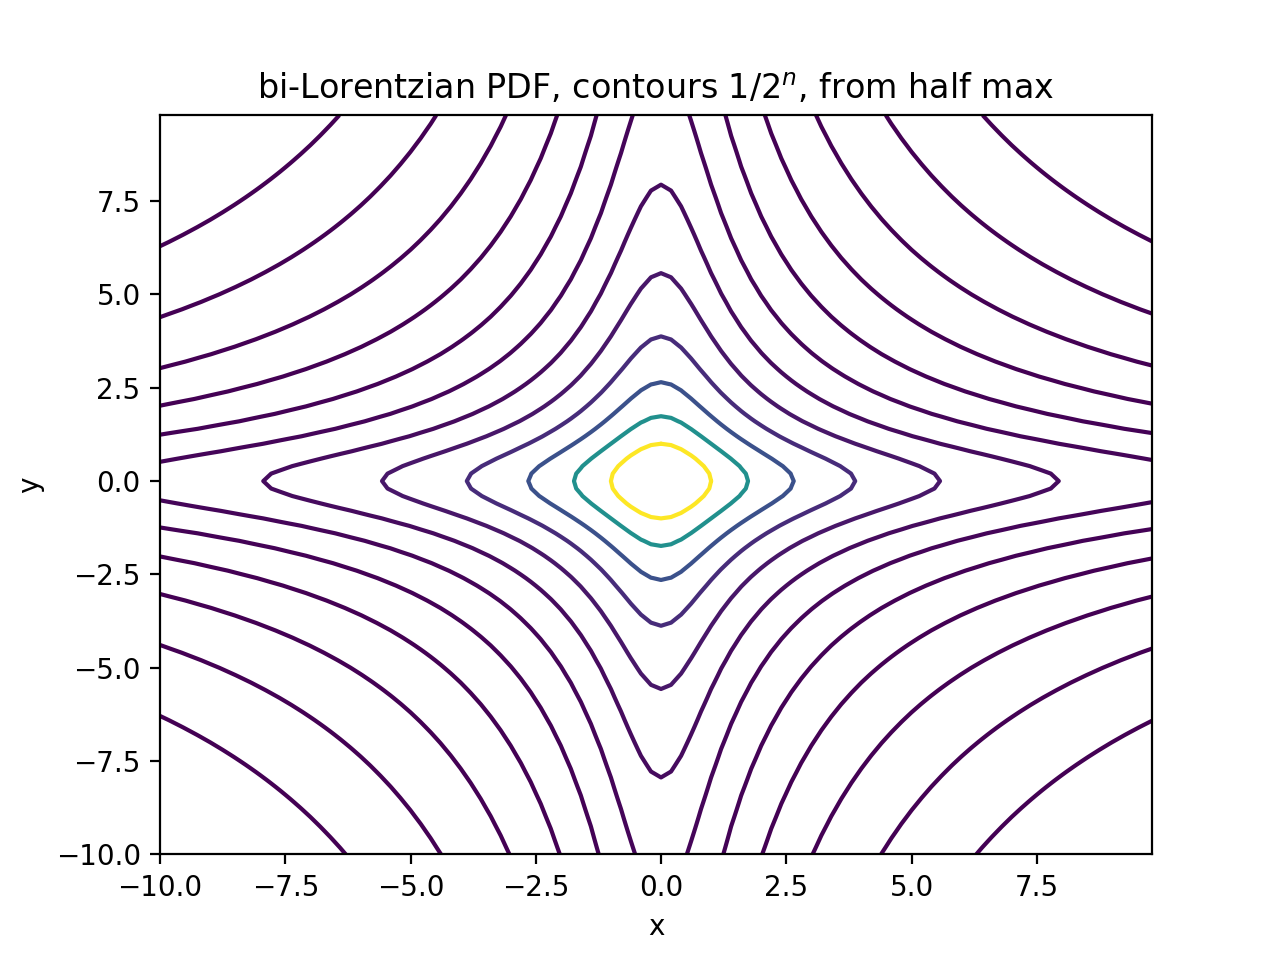

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.special as spc
%matplotlib notebook

# Illustration of the shortcoming described above.
# Joint probability distribution of two Lorentzian-distributed, independent parameters.

domain = 10 # domain size in x and y
xy = np.arange(-domain,domain,0.2)
[x,y] = np.meshgrid(xy,xy)
Pxy = 1/((1+x**2)*(1+y**2)) # Not normalized.
plt.contour(x,y,Pxy, 0.5**np.arange(12,0,-1))
plt.title('bi-Lorentzian PDF, contours $1/2^n$, from half max')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

The illustration above shows what would have been a very selective exploration of our model parameter space, taking jumps along the coordinate axes only. It looks bad in 2D; in higher dimensions it would look even worse. A second mode off at some arbitrary angle would be effectively unreachable. In order to adequately explore the posterior, we must avoid imposing preferred directions. 

__Dimensionless parameters.__ The strategy I outline below will work best on a parameter space with modest dimensionality ($\lesssim 10$) and a single, identifiable scale for each parameter. My first step will be to _isotropize_ the parameter space. The idea is to represent my model parameters in a vector space with no preferred direction, using dimensionless coordinates that may, in principle, take on any real value.

I need to be careful with $Q$ and $B$, as both are positive definite parameters. I will represent both parameters by their logarithms. I am then free to think of these parameters as coordinates on an unbounded domain, much like the components of $\mathbf{r}$. This entails that I must accept a flat prior in $\log Q$ and $\log B$.

Assuming positions are in two dimensions ($\mathbf{r}=[x,y]$), the isotropized vector of model parameters is
$$
    \mathbf{m} = \left[ \frac{x}{s_0}, \frac{y}{s_1}, \frac{\log (Q/Q_0)}{s_2}, \frac{\log (B/B_0)}{s_3} \right].
$$
With this choice of coordinates for the model, I want the origin ($x=y=0, Q=Q_0, B=B_0$) to represent a reasonable initial guess. I also choose scales $\mathbf{s}=[s_0,s_1,s_2,s_3]$ to represent an uncertainty in that guess. None of the scales or offsets has to be very accurate; we are after rough orders of magnitude only. If there is concern about being able to explore the posterior adequately, then the scales can be increased, at the expense of lowering the jump acceptance ratio.

__Isotropic jumps__ are chosen as follows:
1. Choose a direction vector for the jump. 
    1. Choose a vector of uniform deviates $\mathbf{R}$ on $[0,1)$, with the same 
    dimensionality as $\mathbf{m}$.
    1. If $|\mathbf{R}|^2>1$, go to the previous step.$^{\dagger}$ 
    1. $\mathbf{\hat{m}} = \frac{\mathbf{R}}{|\mathbf{R}|}$.
1. Choose one more uniform deviate, $\rho \in [0,1)$. The proposal is:
$$
    \mathbf{m}^* = \mathbf{m} + \frac{J}{2}  \tan\left( \pi \left[ \rho - \frac{1}{2} \right] \right) 
                   \,\mathbf{\hat{m}}.
$$
The parameter $J$ is a dimensionless _jump radius_, which can be tuned to get the desired acceptance ratio for the Markov chain. The tangent can result in any real number, positive or negative, distributed as a Lorentzian with FWHM of unity, while the components of $\mathbf{\hat{m}}$ are all positive.  Transition probability depends only on the Euclidian distance $|\mathbf{m^*-m}|$. Thus, the transition probability matrix is symmetric, which is a requirement for jump proposals in Metropolis-Hatings.

$^{\dagger}$Rejecting the “corner” of the hypercube that lies outside the hypersphere is essential to get an isotropic distribution of jump directions. Unfortunately, rejections become increasingly probable as the dimensionality grows. In 5D, the rejection ratio is $\sim 0.9$. In 11D, it is $\sim 0.999$. This is because the unit hypersphere occupies a smaller and smaller fraction of the unit hypercube as the dimensionality increases, as we learned when doing Monte Carlo integration of hyperspheres. Fortunately, the iterations are not computationally expensive; they require only random number generation and simple arithmetic, plus the interpreter overhead of the `while` loop.

### Simulated Annealing.
The final concept we need for a successful demonstration of MCMC is _burn in_. Unless we have some special insight, the initial guess is often not very good. Even in the relatively modest dimensionality of my example problem $\left(\mathfrak{R}^4\right)$, the Markov chain can get stuck in a local minimum and never find the main peak of the likelihood distribution. Burn in is a strategy based on _simulated annealing_ to locate that main peak.

Simulated annealing is a Markov chain application in which we are looking to minimize a function $E(\mathbf{r})$. The approach has proved particularly successful at solving difficult combinatoric problems such as the [traveling salesman problem](https://en.wikipedia.org/wiki/Travelling_salesman_problem). A variation of the Metropolis-Hastings algorithm is used:
1. Beginning in state $\mathbf{r}$, evaluate the energy $E = E(\mathbf{r})$.
1. Propose a random jump from $\mathbf{r}$ to $\mathbf{r'}$ based on a symmetric transition probability, $T_{\mathbf{rr'}}$.
1. Evaluate $E' = E(\mathbf{r'})$.
1. If $E' / E \le 1$, accept the jump.
1. Otherwise, accept the jump with probability $\exp\left( -\frac{E'-E}{kT}  \right)$.

Notice that the equilibrium posterior distribution for this Markov chain is the familiar Boltzmann distribution from statistical mechanics,
$$
    P(\mathbf{r}|T) \propto \exp\left( -\frac{E(\mathbf{r})}{kT}  \right).
$$
The minimum energy is found by starting at a high temperature, $T$, and running the Metropolis algorithm while gradually reducing the temperature until $kT \ll \min_{\mathbf{r}}E(\mathbf{r})$. This emulates the tendency of a physical system to find its minimum energy when it is cooled slowly. There are many physics applications of simulated annealing, such as the [Ising model of magnetic materials](./ising/).

The idea behind simulated annealing is that a sufficiently high temperature allows the Markov chain to traverse the topography with relative ease, so that it samples all the local minima. As the temperature is slowly lowered, the shallower basins become inaccessible one by one, until only the global minimum is left. Of course, there are never any guarantees of finding an absolute minimum in a high-dimensional space. A lot depends on the _annealing schedule_, by which we mean the sequence of temperatures and Metropolis iterations. The moral of the simulated annealing story is that patience is a virtue.

### MCMC Burn In
Comparing MCMC to simulated annealing, we can make the following analogy: 
$$
  \frac{1}{T}\log\left( \frac{P'}{P} \right) \longleftrightarrow -\frac{\Delta E}{kT},
$$
where the left hand side is the log-likelihood ratio divided by “temperature”. Notice that $E$ is to  be minimized; $P$ is to be maximized. In MCMC, if we divide the log-likelihood ratio by the new, dimensionless parameter $T$, we can run our Metropolis-Hastings algorithm like a simulated annealing scheme. We begin with $T \gg 1$, and slowly reduce the temperature to unity over the course of many MCMC iterations. At that point, the annealed state $\mathbf{r}_{\mathrm{A}}$ reached by the Markov chain is deemed a good initial guess. We throw away all previous iterations, and with $T=1$, we run the MCMC through enough iterations to explore the posterior distribution. The simulated annealing run to obtain $\mathbf{r}_{\mathrm{A}}$ is called _burn in_. 

During burn in, I make occasional automatic updates to the jump radius as follows:
$$
    J' = J \, \frac{A_J}{A_{\mathrm{desired}}},
$$
where $A_J$ is the acceptance ratio observed after many iterations with jump radius $J$, and $A_{\mathrm{desired}}$ is the desired acceptance ratio. According to conventional wisdom, $A_{\mathrm{desired}} \approx 0.3$ is optimal for multi-dimensional MCMC. After burn in, I do not adjust $J$.

My approach to setting up burn in is hands-on: I generate random scenarios with synthetic data, try MCMC on them, and tune my annealing schedule until the MCMC returns reasonably reliable answers.

In [2]:
Nmod = 4     # dimensionality of model (x,y,Q,B)
# Detector parameters (known)
Ndet = 6     # number of detectors
Adet = 0.01  # detector effective area
xdet = np.random.normal(size=Ndet)
ydet = np.random.normal(size=Ndet)
# Implicitly let Delta t = 1. It will be omitted from the model.

# Scale factors relating dimensionless model m[] to x,y,Q,B
s = np.array((1,1,1,1))  # scale factor array
Q0 = 1e6    # expected source activity Q
B0 = 100     # expected background B

# Define variables to hold the data and the unknowns.
# I am doing this here so the variables will be within 
# the scope of the routines in this cell.
data = np.empty( (Ndet) )
x = 0.0
y = 0.0
Q = Q0
B = B0

def model(xm,ym,Qm,Bm):
    """
    Calculate array of expectation values for the data,
    given the chosen model parameters:
    xm = source x-coordinate
    ym = source y-coordinate
    Qm = source activity
    Bm = background count rate
    """
    expected = np.empty((Ndet))
    for n in range(Ndet):
        expected[n] = Bm + Qm * Adet / ((xm-xdet[n])**2 + (ym-ydet[n])**2) / (4*np.pi)
    return expected

def m2xyQB(m):
    """
    Convert dimensionless model parameters to x, y, Q, B
    m = 4-element numpy array of dimensionless model parameters.
    """
    xm = s[0] * m[0]
    ym = s[1] * m[1]
    Qm = Q0 * np.exp( s[2] * m[2] )
    Bm = B0 * np.exp( s[3] * m[3] )
    return (xm,ym,Qm,Bm)

def xyQB2m(xm,ym,Qm,Bm):
    """
    Convert physical parameters x, y, Q, B to dimensionless model m
    """
    m = np.empty((Nmod))
    m[0] = xm / s[0]
    m[1] = ym / s[1]
    m[2] = np.log( Qm/Q0 ) / s[2]
    m[3] = np.log( Bm/B0 ) / s[3]
    return m

def log_factorial(a):
    """
    Returns ln(a!) for integer a.
    """
    return spc.gammaln(a+1)

def log_likelihood(m):
    """
    Evaluate the log-likelihood. Since the likelihood involves products of very
    small numbers, we need to use logarithnms to avoid floating underflow
    problems -- even in double precision.
    
    Parameters:
    m = array of Nmod dimensionless model parameters
    
    Returns: ln(Pr(m|data)) 
    """
    (x,y,Q,B) = m2xyQB(m)
    expected = model(x,y,Q,B)
    log_like = np.sum( log_poisson(expected, data) )
    return log_like

def log_likelihood_with_prior(m):
    """
    Evaluate the log-likelihood. Since the likelihood involves products of very
    small numbers, we need to use logarithnms to avoid floating underflow
    problems -- even in double precision.
    
    This version incorporates prior information about location based on my scenario generation in the next cell.
    
    Parameters:
    m = array of Nmod dimensionless model parameters
    
    Returns: ln(Pr(m|data)) 
    """
    (x,y,Q,B) = m2xyQB(m)
    expected = model(x,y,Q,B)
    log_like = np.sum( log_poisson(expected, data) )
    log_like -= np.sum( (m*s)**2 / 2 ) # prior based on scenario generation (see next cell)
    return log_like


def log_poisson(expected, data):
    """
    For an arbitrary array of expectation values, and
    a data array of the same size, find the log-probability
    using the analytic form of the Poisson distribution.
    The reason for the logarithm
    
    Parameters:
    data = data array (integers)
    expected = array of expectation values (floats, same shape as data)
    
    Returns: Pr(data|expected)
    """
    return ( data*np.log(expected) - expected - log_factorial(data) )

def proposal_gaussian(mi, dilate=1):
    """
    Propose a jump in a random direction in N-dimensional space,
    with the displacement drawn from a Gaussian distributon.
    By default, the Lorentzian has unit standard deviation.
    
    Parameters:
    mi = initial state, an N-dimensional numpy array.
    dilate = factor by which to increase standard deviation of jump distribution
    
    Returns: final state, mf
    """
    return mi + dilate * np.random.normal(size=Nmod)

def proposal_lorentzian(mi, dilate=1):
    """
    Propose a jump in a random direction in N-dimensional space,
    with the displacement drawn from a Lorentzian distributon.
    By default, the Lorentzian has unit FWHM.
    
    Parameters:
    mi = initial state, an N-dimensional numpy array.
    dilate = factor by which to increase FWHM of jump distribution
    
    Returns: final state, mf
    """
    r2=2.
    while(r2>1):
        R = np.random.random(size=Nmod)
        r2 = np.sum(R**2)
    mhat = R/np.sqrt(r2)
    return mi + ( dilate * 0.5 * np.tan( np.pi*(np.random.random()-0.5) ) * mhat )

def metro(m0, jump_func=proposal_lorentzian, loglike_func=log_likelihood, 
          N=10000, T=1, dilate=1):
    mc = np.empty((N,Nmod))
    loglike = np.empty((N)) # can't hurt to track the likelihoods as we go on....
    mc[0,:] = m0
    loglike[0] = loglike_func(m0) 
    i=0
    misses=0
    for i in range(N-1):
        mc[i+1,:] = jump_func(mc[i,:], dilate=dilate) # propose a jump
        loglike[i+1] = loglike_func(mc[i+1,:]) 
        logratio = loglike[i+1] - loglike[i]
        if not(np.isfinite(loglike[i+1])):
            logratio = -1e100  # ensure rejection
        if logratio < 0:
            if (np.log(np.random.rand()) > logratio/T): # reject the jump
                mc[i+1,:] = mc[i,:]
                loglike[i+1] = loglike[i]
                misses+=1
    return mc, (N-misses)/N, loglike

In [3]:
def confplot(x, y, LL, conf_lo=50, conf_hi=95):
    N = np.size(LL)
    n_outer = int(round((1-conf_hi/100)*N))
    n_inner = int(round((1-conf_lo/100)*N))
    ssrank = np.argsort(LL, axis=None)
    band1 = ssrank[0:n_outer]
    band2 = ssrank[n_outer:n_inner]
    band3 = ssrank[n_inner:-1]
    plt.scatter(x[band1], y[band1], s=1, c='b', marker='.', label = '>'+str(conf_hi)+'%')
    plt.scatter(x[band2], y[band2], s=1, c='g', marker='.', label = str(conf_hi)+'-'+str(conf_lo)+'%')
    plt.scatter(x[band3], y[band3], s=1, c='c', marker='.', label = '<'+str(conf_lo)+'%')
    plt.scatter(x[-1], y[-1], s=20, c='k', marker='x', label = 'Max Likelihood')

In [4]:
# Generate a random scenario (unknowns and data)
mtrue = np.random.normal(size=Nmod) / s
(x,y,Q,B) = m2xyQB(mtrue)
data = np.random.poisson(model(x,y,Q,B))

In [5]:
# Have a look at the scenario and the data.
print('source:', Q)
print('background:', B)
print('data set (counts):',data)

source: 850070.403617059
background: 101.18448538372411
data set (counts): [  698  1577   147  1189   305 23865]


In [6]:
# Burn in by simulated annealing
m0=np.zeros((Nmod))
target_acceptance = 0.3
jump_radius = 3.0

# Arrays in which to store the history of the annealing process.
T_history            = np.array(())
accept_ratio_history = np.array(())
loglike_history      = np.array(())

for T in (10**np.arange(2,0,-0.02)):
        Niter = 2000
        (mc, accept_ratio, loglike) = metro(m0, N=Niter, T=T, dilate=jump_radius,
                    loglike_func = log_likelihood_with_prior)
        # Store results of this run at temperature T
        T_history = np.append(T_history, T*np.ones((Niter)))
        accept_ratio_history = np.append(accept_ratio_history, accept_ratio*np.ones((Niter)))
        loglike_history = np.append(loglike_history, loglike)
        
        # print(Niter,' iterations at T = ', T, '; jump factor = ', jump_radius,
        #      '; acceptance ratio = ', accept_ratio)
        
        jump_radius *= (accept_ratio / target_acceptance)
        m0 = mc[-1]

/var/folders/4b/jg9_zw7h8xj33m00r6bggh880000gn/T/ipykernel_51456/1192559029.py:44: RuntimeWarning: overflow encountered in exp
  Qm = Q0 * np.exp( s[2] * m[2] )
/var/folders/4b/jg9_zw7h8xj33m00r6bggh880000gn/T/ipykernel_51456/1192559029.py:45: RuntimeWarning: overflow encountered in exp
  Bm = B0 * np.exp( s[3] * m[3] )
/var/folders/4b/jg9_zw7h8xj33m00r6bggh880000gn/T/ipykernel_51456/1192559029.py:114: RuntimeWarning: invalid value encountered in subtract
  return ( data*np.log(expected) - expected - log_factorial(data) )
/var/folders/4b/jg9_zw7h8xj33m00r6bggh880000gn/T/ipykernel_51456/1192559029.py:114: RuntimeWarning: divide by zero encountered in log
  return ( data*np.log(expected) - expected - log_factorial(data) )


<IPython.core.display.Javascript object>


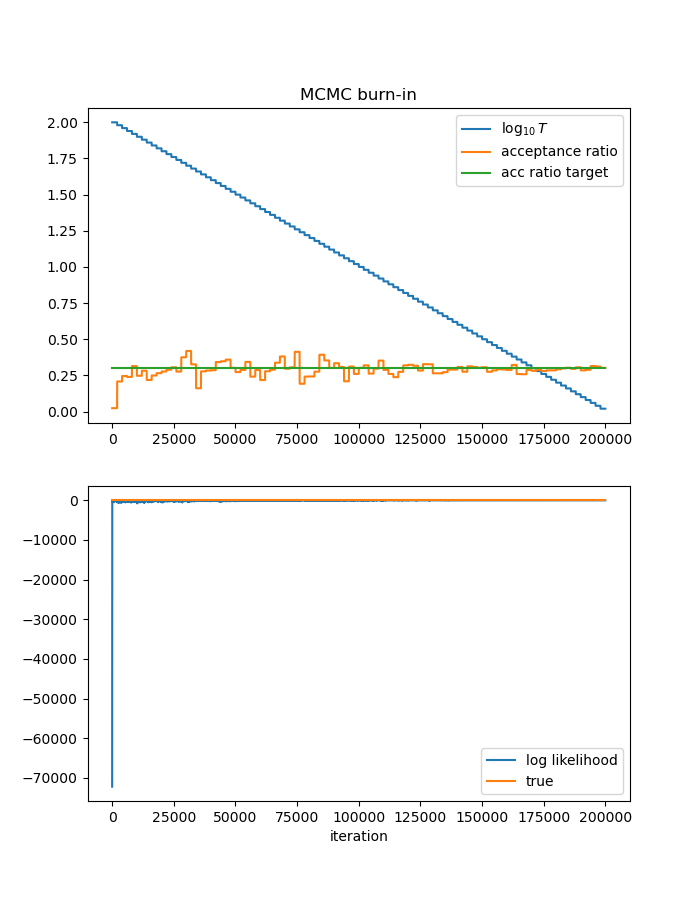

In [7]:
# Plot the burn in history

#T_history            = np.array(())
#accept_ratio_history = np.array(())
#loglike_history      = np.array(())

plt.figure(figsize=(7,9))

plt.subplot(211)
plt.plot(np.log10(T_history), label=r'$\log_{10} T$')
plt.plot(accept_ratio_history, label='acceptance ratio')
plt.plot(np.array((0,loglike_history.size)),target_acceptance*np.array((1,1)),label='acc ratio target')
plt.legend()
plt.title('MCMC burn-in')

plt.subplot(212)
plt.plot(loglike_history, label='log likelihood')
plt.plot(np.array((0,loglike_history.size)),log_likelihood(mtrue)*np.array((1,1)),label='true')
plt.legend()
plt.xlabel('iteration')

plt.show()

In [8]:
# Run MCMC from where we left off after burn-in.
m0 = mc[-1]
# m0 = xyQB2m(.73,1.24,7.1e6,23.4)
(mc, accept_ratio, loglike) = metro(m0, N=1800000, dilate=jump_radius,
                loglike_func = log_likelihood_with_prior)

# Convert mc back to physical variables
Nmc = mc.shape[0]
xmc = np.empty((Nmc))
ymc = np.empty((Nmc))
Qmc = np.empty((Nmc))
Bmc = np.empty((Nmc))
for i in range(Nmc):
    (xmc[i],ymc[i],Qmc[i],Bmc[i]) = m2xyQB(mc[i])

/var/folders/4b/jg9_zw7h8xj33m00r6bggh880000gn/T/ipykernel_51456/1192559029.py:44: RuntimeWarning: overflow encountered in exp
  Qm = Q0 * np.exp( s[2] * m[2] )
/var/folders/4b/jg9_zw7h8xj33m00r6bggh880000gn/T/ipykernel_51456/1192559029.py:45: RuntimeWarning: overflow encountered in exp
  Bm = B0 * np.exp( s[3] * m[3] )
/var/folders/4b/jg9_zw7h8xj33m00r6bggh880000gn/T/ipykernel_51456/1192559029.py:114: RuntimeWarning: invalid value encountered in subtract
  return ( data*np.log(expected) - expected - log_factorial(data) )
/var/folders/4b/jg9_zw7h8xj33m00r6bggh880000gn/T/ipykernel_51456/1192559029.py:114: RuntimeWarning: divide by zero encountered in log
  return ( data*np.log(expected) - expected - log_factorial(data) )


<IPython.core.display.Javascript object>


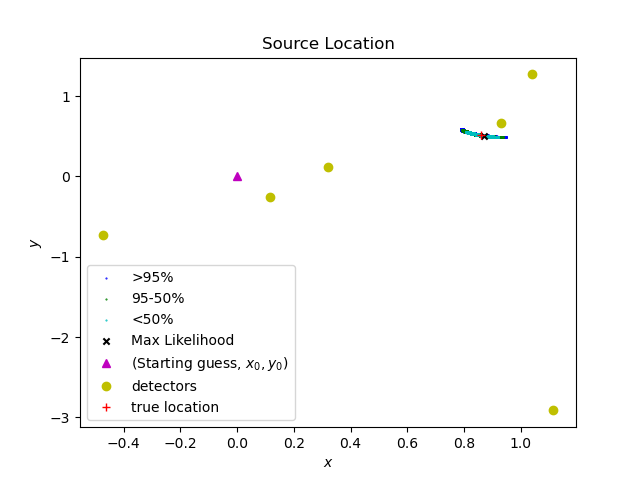

In [9]:
plt.figure()
confplot(xmc,ymc,loglike)
plt.plot(0,0,'m^', label='(Starting guess, $x_0, y_0$)')
plt.plot(xdet,ydet,'yo', label='detectors')
plt.plot(x,y, 'r+', label='true location')
plt.title('Source Location')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.legend()
plt.show();



<IPython.core.display.Javascript object>


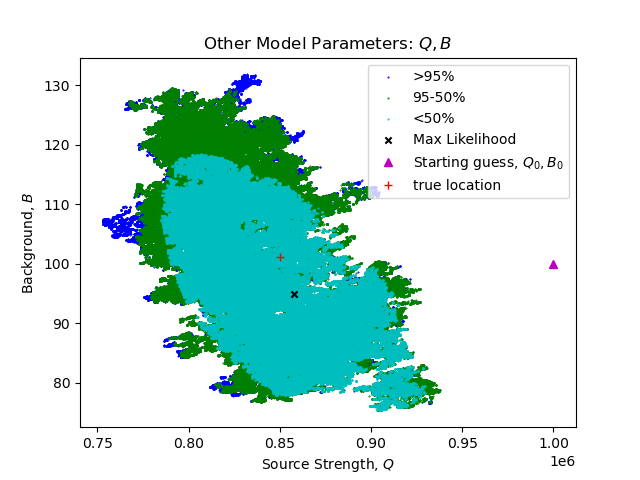

In [10]:
plt.figure()
confplot(Qmc,Bmc, loglike)
plt.plot(Q0,B0,'m^', label='Starting guess, $Q_0, B_0$')
plt.plot(Q,B, 'r+', label='true location')
plt.title('Other Model Parameters: $Q,B$')
plt.xlabel('Source Strength, $Q$')
plt.ylabel('Background, $B$')
plt.legend()
plt.show();



acceptance ratio =  0.26887055555555556


<IPython.core.display.Javascript object>


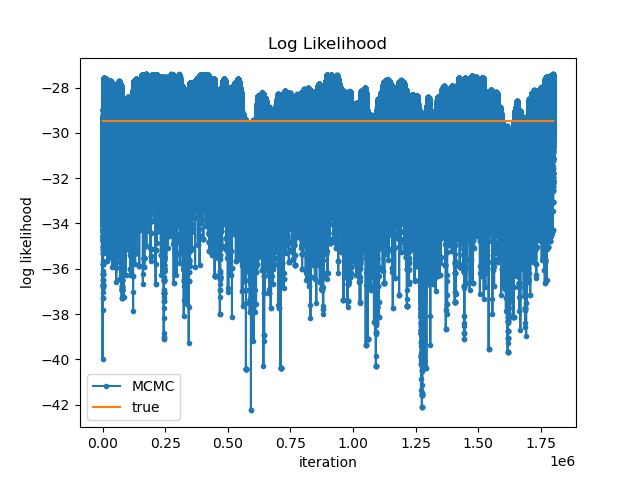

In [11]:
print('acceptance ratio = ',accept_ratio)
plt.figure()
plt.plot(loglike,'.-',label='MCMC')
plt.plot(np.array((0,loglike.size)),log_likelihood(mtrue)*np.array((1,1)),label='true')
plt.title('Log Likelihood')
plt.xlabel('iteration')
plt.ylabel('log likelihood')
plt.legend()
plt.show()


### Comments

__More results [here](https://www.youtube.com/watch?v=ALiLGgn3YGM).__

I have put considerable effort into trying to ensure the MCMC fully explores the posterior distribution. To this end, I have developed:
- Lorentzian jumps
- “isotropized”, dimensionless coordinates$^\dagger$
- burn in by simulated annealing

Essentially, I've tried to give MCMC a leg up on exploring the posterior while letting it be _Markovian_. Recall that a Markov chain $\mathbf{r}_{1},\mathbf{r}_{2},\mathbf{r}_{3},...$ has the defining property:
$$
    \Pr(\mathbf{r}_{n}|\mathbf{r}_{n-1},\mathbf{r}_{n-2},\mathbf{r}_{n-3},...)
    = \Pr(\mathbf{r}_{n}|\mathbf{r}_{n-1}).
$$
In words, the Markov chain should have no memory of its past. This property was closely related to the concept of detailed balance, which allows Metropolis-Hastings to sample from the posterior distribution, which in turn is the goal of MCMC. Notice that simulated annealing and my jump radius updates during burn in do not satisfy this condition; that is why I discard everything from burn in except the initial state $\mathbf{R}_{\mathrm{A}}$ before restarting MCMC.

The state of the art is a strategem called [_parallel tempering_](https://en.wikipedia.org/wiki/Parallel_tempering), in which a collection of MCMC simulations run in parallel at different temperatures. Here, temperature is defined in the same way as it was for simulated annealing. These parallel chains trade information and work together to explore the posterior intelligently. The sequence of collective states for this system is Markovian because those information exchanges are triggered and implemented solely on the basis of present conditions. Parallel tempering is an efficient, automatic approach to exploring the posterior without restarts.

$^\dagger$I use scare quotes because, as it turns out, strong correlations between parameters often emerge. These constitute important localized anisotropies (prominent diagonal ridges) in the posterior distribution, which are not anticipated by my dimensionless coordinates. MCMC does not explore these narrow ridges optimally.
